In [130]:
import os
import librosa
import sklearn
import scipy
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import noisereduce as nr
import seaborn as sns
from tqdm import tqdm
import warnings
from itertools import product

from scipy.io import wavfile
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


In [2]:
# Define paths
csv_file = 'common-voice/versions/2/cv-valid-train.csv'
mp3_folder = 'common-voice/versions/2/cv-valid-train'
output_csv = "common-voice/versions/2/train_features_filter.csv"

sample_rate = 22050          # sample_rate
length_of_audio = 5 # seconds

In [3]:
df = pd.read_csv(csv_file)
df.drop(['text', 'up_votes', 'down_votes', 'duration'], axis=1, inplace=True)
df.dropna(inplace=True)
print(df.shape)
print(df.head(5))

(63163, 4)
                            filename        age  gender     accent
5   cv-valid-train/sample-000005.mp3   twenties  female         us
8   cv-valid-train/sample-000008.mp3  seventies    male         us
13  cv-valid-train/sample-000013.mp3   thirties  female         us
14  cv-valid-train/sample-000014.mp3    sixties    male    england
19  cv-valid-train/sample-000019.mp3    fifties    male  australia


In [4]:
df = df[df['gender'] != 'other']
print(df.shape)

(62421, 4)


In [5]:
tags = {
    'age': df['age'].unique(),
    'gender': df['gender'].unique(),
    'accent': df['accent'].unique()
}
mapping = {}
for key in tags:
    for id, option in enumerate(tags[key]):
        mapping[option] = id
# print(mapping)

In [6]:
print(mapping)

{'twenties': 0, 'seventies': 1, 'thirties': 2, 'sixties': 3, 'fifties': 4, 'fourties': 5, 'teens': 6, 'eighties': 7, 'female': 0, 'male': 1, 'us': 0, 'england': 1, 'australia': 2, 'indian': 3, 'canada': 4, 'malaysia': 5, 'ireland': 6, 'bermuda': 7, 'scotland': 8, 'african': 9, 'newzealand': 10, 'wales': 11, 'philippines': 12, 'singapore': 13, 'hongkong': 14, 'southatlandtic': 15}


In [7]:
df['age'] = df['age'].map(mapping)
df['gender'] = df['gender'].map(mapping)
df['accent'] = df['accent'].map(mapping)

In [8]:
print(df.head(5))
print(df.shape)

                            filename  age  gender  accent
5   cv-valid-train/sample-000005.mp3    0       0       0
8   cv-valid-train/sample-000008.mp3    1       1       0
13  cv-valid-train/sample-000013.mp3    2       0       0
14  cv-valid-train/sample-000014.mp3    3       1       1
19  cv-valid-train/sample-000019.mp3    4       1       2
(62421, 4)


In [9]:
def preprocessing(file):
    y, sr = librosa.load(file, sr=sample_rate)
    reduced_noise = nr.reduce_noise(y=y, sr=sample_rate, stationary=False)
    y_trim, _ = librosa.effects.trim(reduced_noise, top_db=20)
    return y_trim, sr

In [10]:
def onset(y):
    onsets = librosa.onset.onset_detect(y=y, sr=sample_rate, units="time", hop_length=128, backtrack=True)
    number_of_words = len(onsets)
    duration = librosa.get_duration(y=y,sr=sample_rate)
    word_per_sec = number_of_words/duration
    return  number_of_words, duration, word_per_sec

In [11]:
def pitch(y):
    f0, _, _ = librosa.pyin(y, sr=sample_rate, fmin=10, fmax=8000, frame_length=1024)
    f0_values = {
    'f0_mean' : np.nanmean(f0),
    'f0_median' : np.nanmedian(f0),    
    'f0_std' : np.nanstd(f0),
    'f0_5-percentile' : np.nanpercentile(f0, 5),
    'f0_95-percentile' : np.nanpercentile(f0, 95),
    }
    return f0_values

In [12]:
def fft(y, fixed_length = sample_rate * length_of_audio):
    if len(y) < fixed_length:
        y_fft = np.pad(y, (0, fixed_length - len(y)), mode='constant')
    else:
        y_fft = y[:fixed_length]
        
    y_freq = np.abs(scipy.fftpack.fft(y_fft))
    f = np.linspace(0, sample_rate, len(y_freq))  # Frequency axis
    
    # Filter frequencies in the range [100, 1000] Hz
    freq_range = (f >= 100) & (f <= 1000)
    filtered_frequencies = f[freq_range]
    filtered_magnitudes = y_freq[freq_range]
    
    # Restrict data points to 500 by uniform sampling
    indices = np.linspace(0, len(filtered_frequencies) - 1, 500, dtype=int)
    sampled_frequencies = filtered_frequencies[indices]
    sampled_magnitudes = filtered_magnitudes[indices]
    result = {sampled_frequencies[i]: sampled_magnitudes[i] for i in range(len(indices))}
    return result

In [13]:
new_features = {
    'number_of_words': [],
    'duration': [],
    'word_per_sec': [],
    'tempo': []
}

mp3_filename = "cv-valid-train/sample-000005.mp3" 
mp3_file_path = os.path.join(mp3_folder, mp3_filename)
y, _ = librosa.load(mp3_file_path, sr= sample_rate)
y_trim,_ = preprocessing(mp3_file_path)

f0_values = pitch(y=y_trim)
for key in f0_values.keys():
    new_features[key] = []

magnitudes = fft(y=y_trim)
for key in magnitudes.keys():
    new_features[key] = []


In [14]:
# Group by age, gender, accent combination
grouped = df.groupby(['age', 'gender', 'accent'])[['filename', 'age', 'gender', 'accent']]
group_sizes = grouped.size()
unique_combinations = group_sizes.reset_index(name='count')
n_rows_per_group = 10000 // len(grouped)

In [15]:
df_subset = grouped.apply(lambda group: group.sample(n=min(len(group), n_rows_per_group), random_state=0))
df_subset = df_subset.reset_index(drop=True)

In [16]:
df_subset.shape

(7465, 4)

In [26]:
df_sampled = df_subset.iloc[::70]
print(df_sampled.head(10))

                             filename  age  gender  accent
0    cv-valid-train/sample-167332.mp3    0       0       0
70   cv-valid-train/sample-075395.mp3    0       0       1
140  cv-valid-train/sample-028354.mp3    0       0       2
210  cv-valid-train/sample-084078.mp3    0       0       3
280  cv-valid-train/sample-078083.mp3    0       0       4
350  cv-valid-train/sample-067050.mp3    0       0       5
420  cv-valid-train/sample-083042.mp3    0       0       7
490  cv-valid-train/sample-109456.mp3    0       0      12
560  cv-valid-train/sample-141223.mp3    0       0      13
630  cv-valid-train/sample-088905.mp3    0       1       0


In [27]:
n_rows = len(df_subset)
new_columns = pd.DataFrame(np.nan, index=range(n_rows), columns=new_features.keys())
# Step 4: Add the new columns to the DataFrame
df_subset = pd.concat([df_subset, new_columns], axis=1)

In [29]:
print(df_subset.head(1))

                           filename  age  gender  accent  number_of_words  \
0  cv-valid-train/sample-167332.mp3    0       0       0              NaN   

   duration  word_per_sec  tempo  f0_mean  f0_median  ...  983.40892  \
0       NaN           NaN    NaN      NaN        NaN  ...        NaN   

   985.208936  987.008952  988.808969  990.608985  992.409001  994.209018  \
0         NaN         NaN         NaN         NaN         NaN         NaN   

   996.009034  997.80905  999.809069  
0         NaN        NaN         NaN  

[1 rows x 513 columns]


In [30]:
# Iterate over each row in the DataFrame
for index, row in tqdm(df_subset.iterrows(), total=len(df_subset), desc="Processing MP3 files", unit="file"):
    mp3_filename = row['filename']  # Adjust if column name differs
    mp3_file_path = os.path.join(mp3_folder, mp3_filename)

    # Check if the MP3 file exists
    if os.path.exists(mp3_file_path):
        # preprocessing
        y, _ = preprocessing(mp3_file_path)
        # Onset
        number_of_words, duration, word_per_sec  = onset(y=y)
        df_subset.at[index, 'number_of_words'] = number_of_words
        df_subset.at[index, 'duration'] = duration
        df_subset.at[index, 'word_per_sec'] = word_per_sec
        # Tempo
        tempo = librosa.beat.beat_track(y=y, sr=sample_rate, start_bpm=10)[0]
        df_subset.at[index, 'tempo'] = tempo
        # Pitch
        f0_values = pitch(y=y)
        for i, v in f0_values.items():
            df_subset.at[index, i] = v
        # FFT
        magnitudes = fft(y=y)
        for i, v in magnitudes.items():
            df_subset.at[index, i] = v

print("Finished extracting MP3 files.")

Processing MP3 files:   9%|▉         | 706/7465 [56:22<10:06:25,  5.38s/file]C:\Users\User\AppData\Local\Temp\ipykernel_71428\2366691500.py:4: RuntimeWarning: Mean of empty slice
  'f0_mean' : np.nanmean(f0),
C:\Users\User\AppData\Local\Temp\ipykernel_71428\2366691500.py:5: RuntimeWarning: All-NaN slice encountered
  'f0_median' : np.nanmedian(f0),
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\numpy\lib\nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
Processing MP3 files: 100%|██████████| 7465/7465 [9:27:30<00:00,  4.56s/file]     

Finished extracting MP3 files.


In [32]:
df_subset.to_csv(output_csv, index=False)

In [31]:
df_subset.shape

(7465, 513)

In [33]:
df_features = pd.read_csv(output_csv)
df_features.shape

(7465, 513)

In [34]:
df_features.dropna(inplace=True)
df_features.shape

(7457, 513)

In [108]:
df_features.head(10)

,filename,age,gender,accent,number_of_words,duration,word_per_sec,tempo,f0_mean,f0_median,...,983.7179215,985.3716921,987.3010913,988.9548619,990.8842611,992.5380317,994.4674308,996.1212015,998.0506006,999.9799997
0,cv-valid-train/sample-000005.mp3,0,0,0,21,3.628118,5.788125,23.490767,441.669688,143.784808,...,23.941086,11.156344,23.575853,35.138096,33.448460,17.500954,18.639141,48.597730,34.941612,11.481312
1,cv-valid-train/sample-000008.mp3,1,1,0,13,3.628118,3.583125,29.363459,115.302184,118.495711,...,20.311329,22.578304,3.778803,43.344814,19.326050,45.370827,28.433064,58.963547,29.866924,45.801320
2,cv-valid-train/sample-000013.mp3,2,0,0,17,3.628118,4.685625,24.609375,120.411044,119.864566,...,9.838939,13.903697,15.007976,15.439333,19.256716,16.809599,19.945164,13.930158,14.699120,18.509203
3,cv-valid-train/sample-000014.mp3,3,1,1,17,3.628118,4.685625,31.901042,93.963663,95.136569,...,71.754900,75.957760,51.377520,57.508507,56.205044,50.522606,56.362793,50.866814,34.901900,27.500670
4,cv-valid-train/sample-000019.mp3,4,1,2,15,3.628118,4.134375,33.999794,191.337211,188.087665,...,6.734560,6.936771,6.311212,6.251774,10.855608,5.114443,2.778959,9.423573,10.442585,7.890206
5,cv-valid-train/sample-000020.mp3,2,1,1,24,3.628118,6.615000,25.584004,237.195843,234.253711,...,3.254005,0.724123,1.006440,2.057010,3.929647,2.775851,1.190418,1.759699,2.172188,3.363522
6,cv-valid-train/sample-000023.mp3,2,1,0,14,3.628118,3.858750,35.397046,119.396186,118.487804,...,3.921648,2.461717,4.812189,2.702581,6.698098,3.515016,2.128659,2.983964,6.272696,4.081430
7,cv-valid-train/sample-000026.mp3,0,0,2,19,3.628118,5.236875,36.394146,156.550380,152.774657,...,5.758038,13.280662,4.983834,7.218499,12.619424,7.448330,5.833411,7.236699,9.309655,6.557485
8,cv-valid-train/sample-000027.mp3,0,1,2,13,3.628118,3.583125,37.449049,107.793687,104.952648,...,6.765611,2.846069,6.742152,4.354986,7.960336,9.396173,11.839003,6.329178,14.046695,16.159222
9,cv-valid-train/sample-000029.mp3,2,1,3,15,3.628118,4.134375,25.087227,158.777576,157.251296,...,0.818589,1.674236,2.380337,1.939025,2.358392,2.351663,4.493119,2.771089,5.427670,5.719730


# Predict

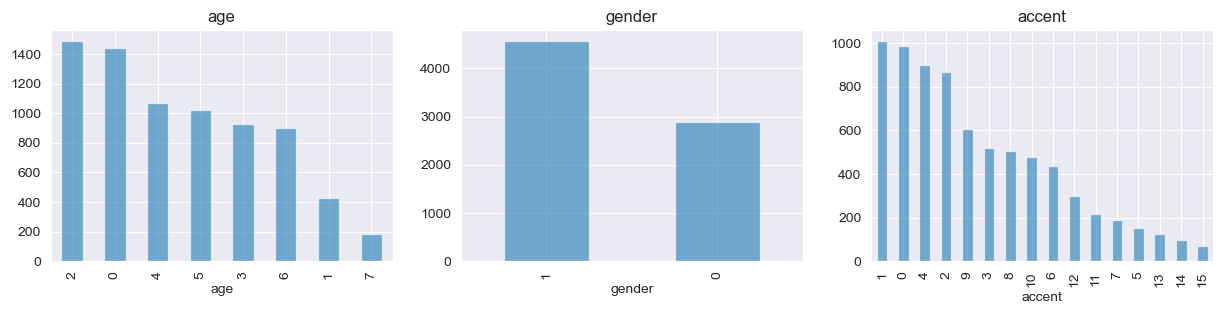

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3))
for i, c in enumerate(["age", "gender", "accent"]):
    df_features[c].value_counts().plot.bar(title=c, ax=axes[i], alpha=0.6)
plt.show();

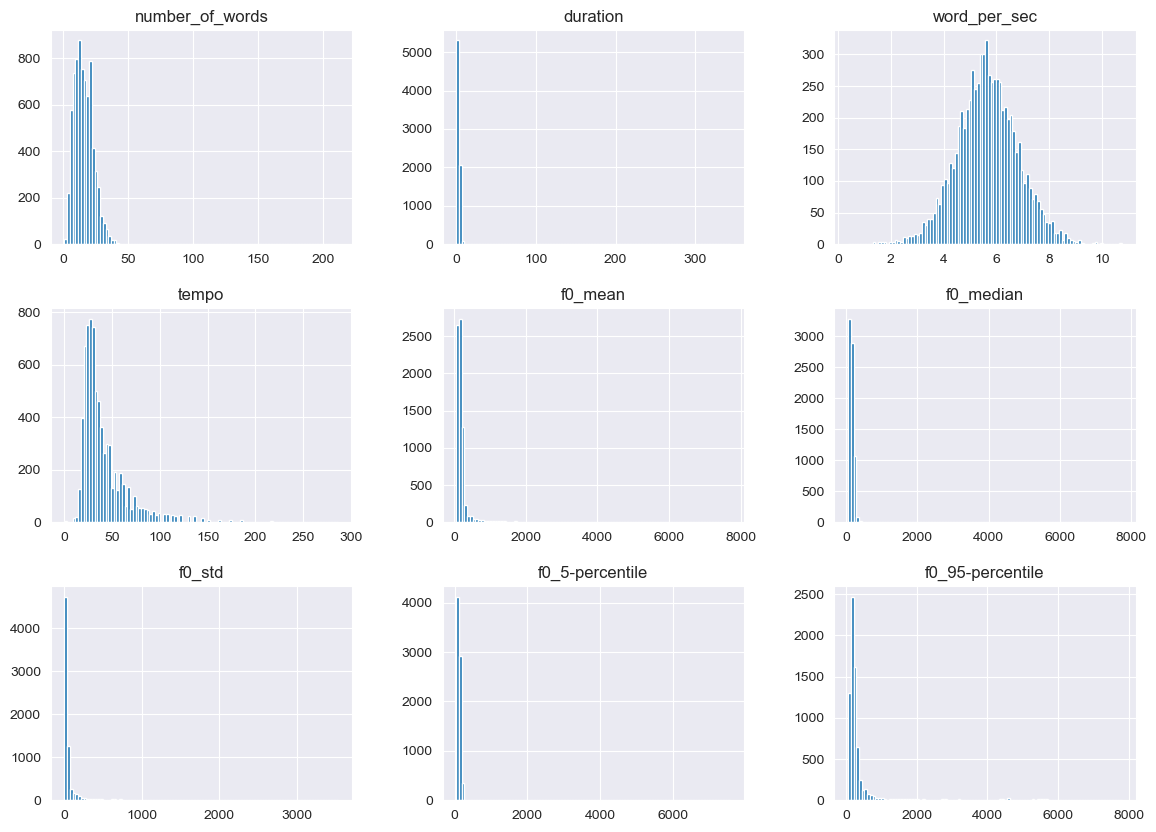

In [36]:
# df_features.drop(columns=["age", "gender", "filename", "accent"]).hist(bins=100, figsize=(14, 10))
df_features.iloc[:, :13].drop(columns=["age", "gender", "filename", "accent"], errors='ignore').hist(bins=100, figsize=(14, 10))
plt.show();

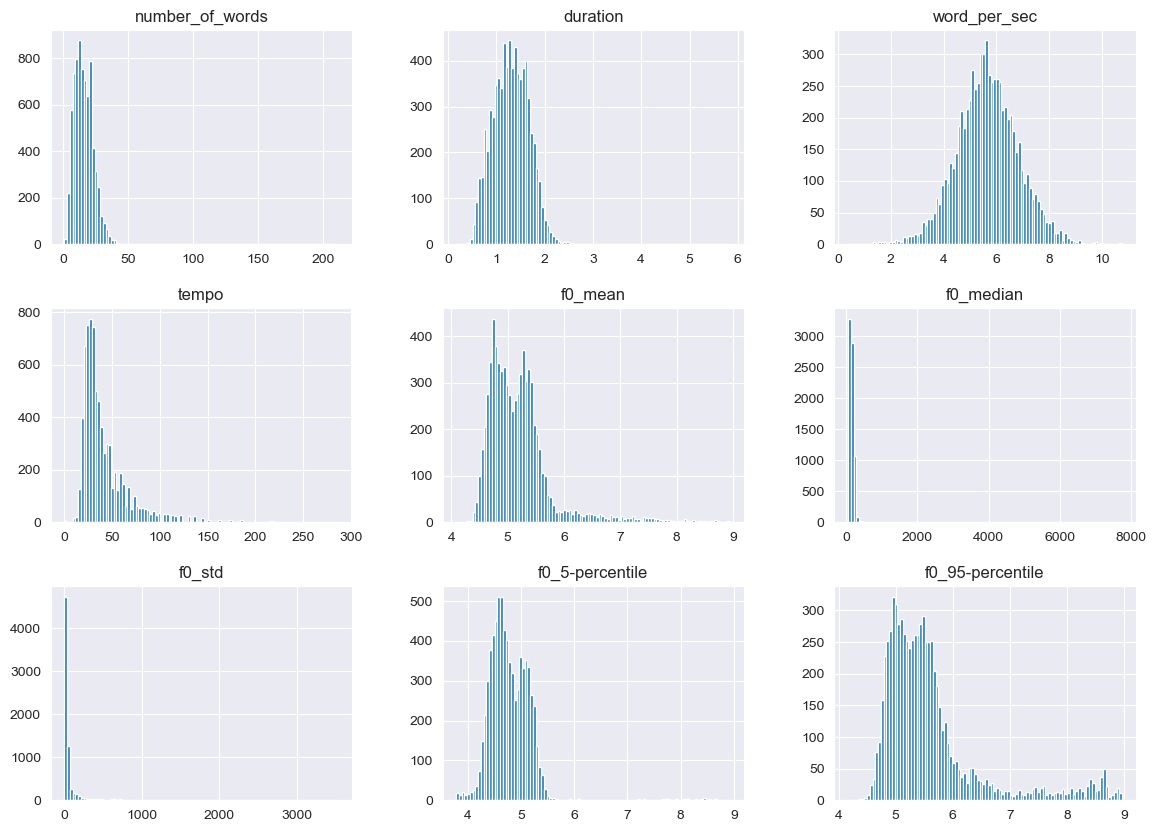

In [37]:
# Applies log1p on features that are not age, gender, filename or words_per_second
df_features_transform = df_features.apply(
    lambda x: np.log1p(x)
    if x.name in ["duration", "f0_mean", "f0_median" "f0_std", "f0_5-percentile", "f0_95-percentile"]
    else x)

# Let's look at the distribution once more
df_features_transform.iloc[:, :13].drop(columns=["age", "gender", "filename", "accent"], errors='ignore').hist(bins=100, figsize=(14, 10))
plt.show();

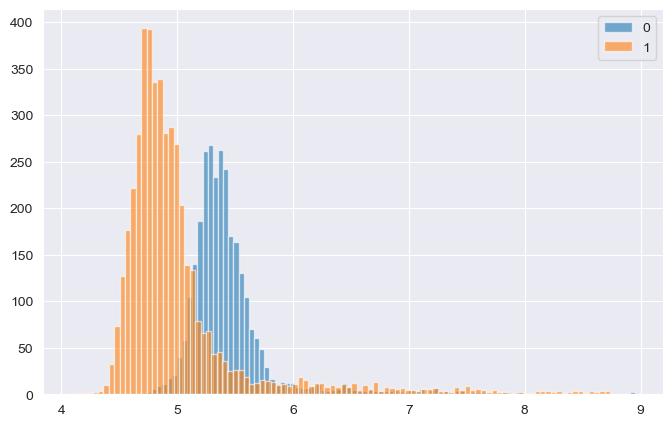

In [131]:
for g in df_features_transform.gender.unique():
    df_features_transform[df_features_transform["gender"].eq(g)]["f0_mean"].hist(
        bins=100, figsize=(8, 5), label=g, alpha=0.6)
plt.legend()
plt.show();

In [91]:
df_first_13 = df_features_transform.iloc[:, :13]
print(df_first_13.shape)

(7457, 13)


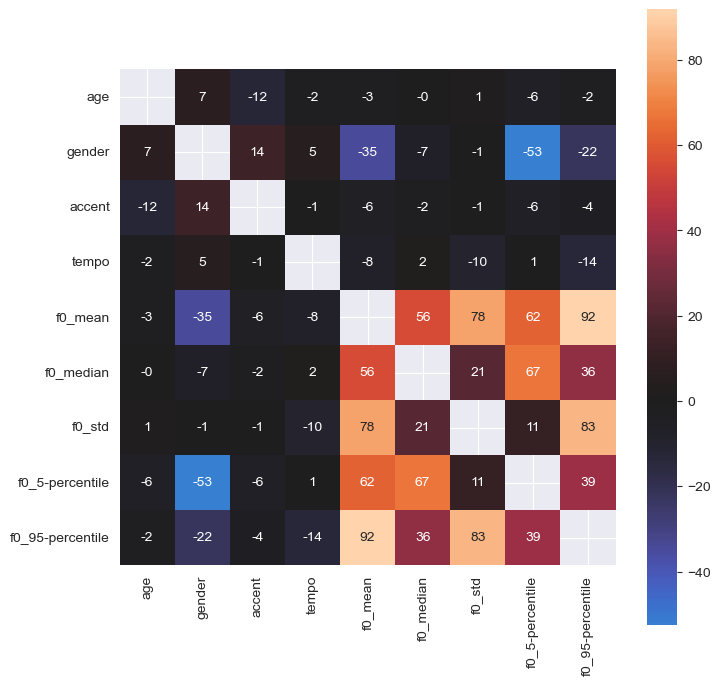

In [92]:
plt.figure(figsize=(8, 8))
df_corr = df_features_transform.iloc[:, 1:13].drop(columns=["filename", "number_of_words", "duration","word_per_sec"], errors='ignore').corr() * 100
sns.heatmap(df_corr, square=True, annot=True, fmt=".0f", 
            mask=np.eye(len(df_corr)), center=0)
plt.show()

In [93]:
targets = ["age","gender","accent"]
def draw_pca_capture(dataframe):
    x = dataframe.drop(columns=["filename", "age","gender","accent"]).reset_index(drop=True)
    pca = PCA()
    pca.fit(x)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    print(np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.9) + 1)
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    

2


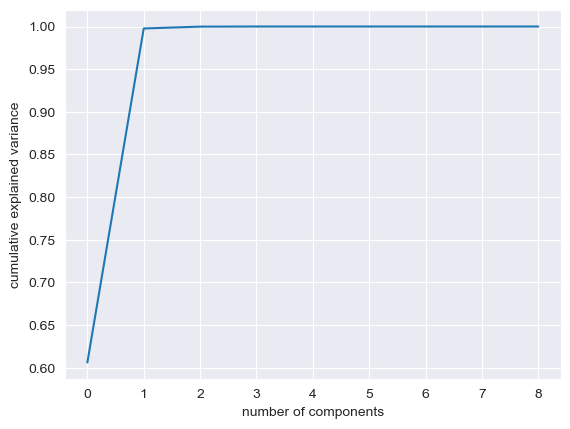

91


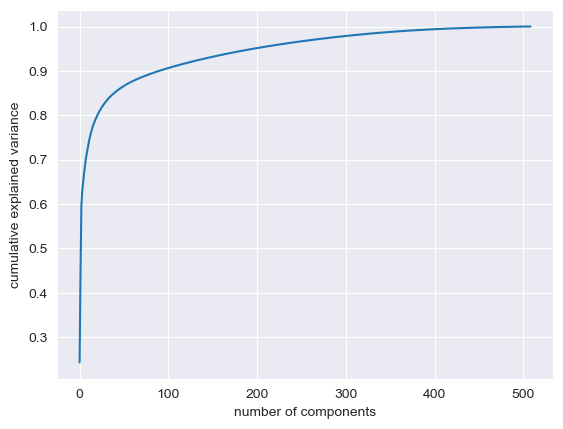

In [94]:
for dataframe in [df_first_13,df_features_transform]:
    draw_pca_capture(dataframe)
    plt.show()
    

In [105]:
def draw_2d_PCA(dataframe, target):
    x = dataframe.drop(columns=["filename", "age","gender","accent"]).reset_index(drop=True)
    print(target)
    y = dataframe[target].values
    pca = PCA(n_components=2)
    X_PCA = pca.fit_transform(x)
    df_pca = pd.DataFrame(X_PCA, columns=["PCA1", "PCA2"])
    df_pca[target] = y
    # print(df_pca.head(1))

    # Plot the PCA-transformed data
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(df_pca["PCA1"], df_pca["PCA2"], c=df_pca[target], cmap="viridis", alpha=0.7)
    plt.colorbar(scatter, label=target)
    plt.title("PCA Visualization (2 Components)", fontsize=14)
    plt.xlabel("Principal Component 1", fontsize=12)
    plt.ylabel("Principal Component 2", fontsize=12)
    plt.grid()
    plt.show()

age


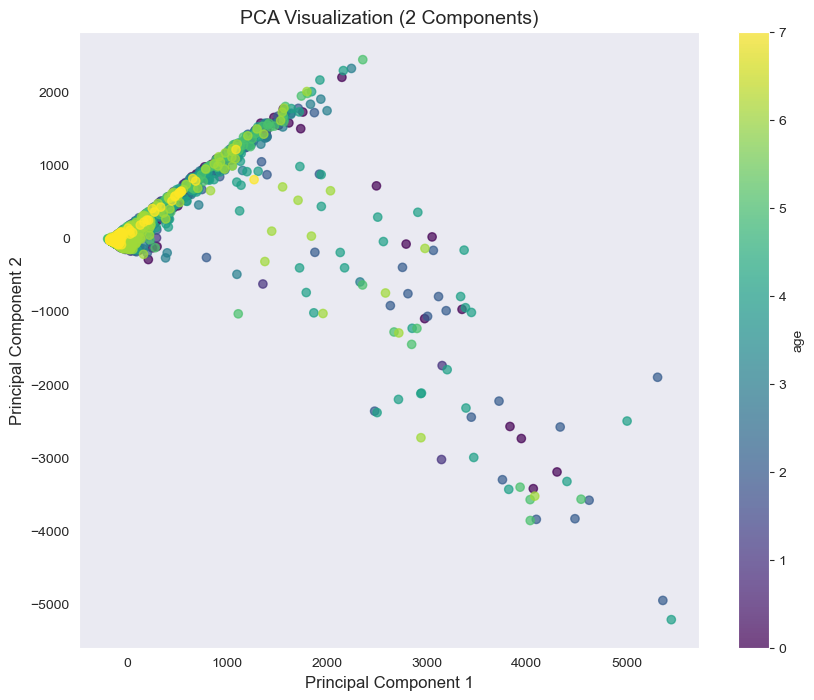

gender


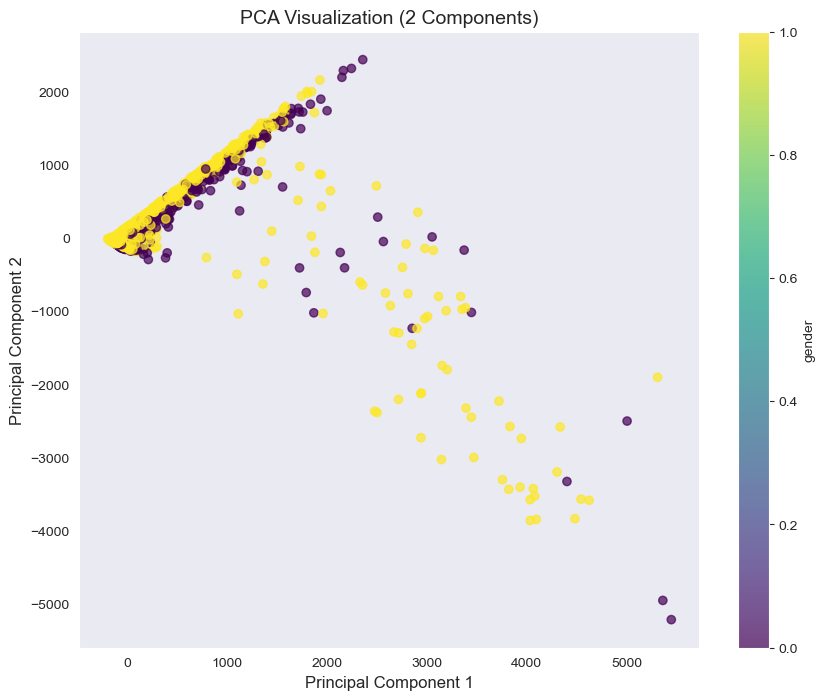

accent


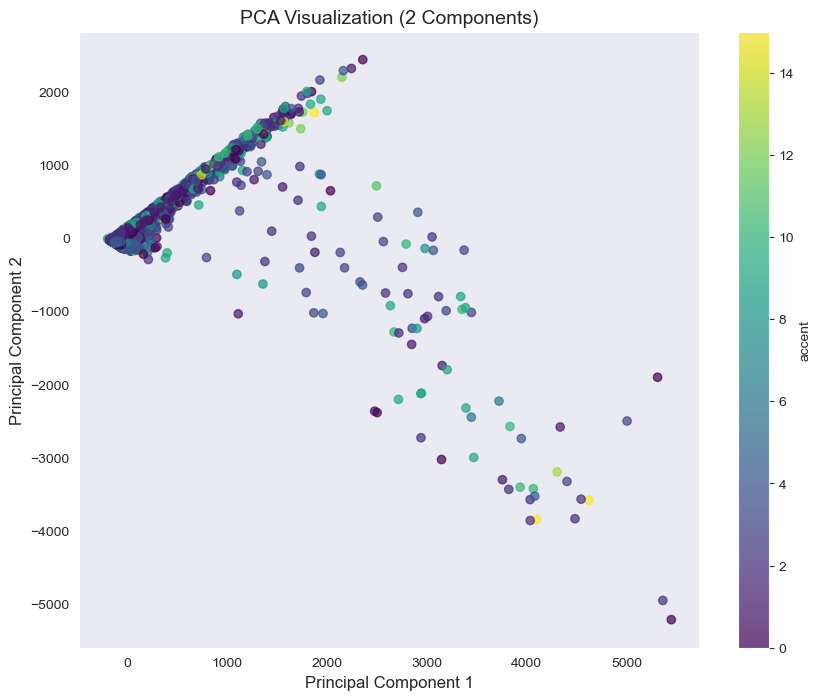

age


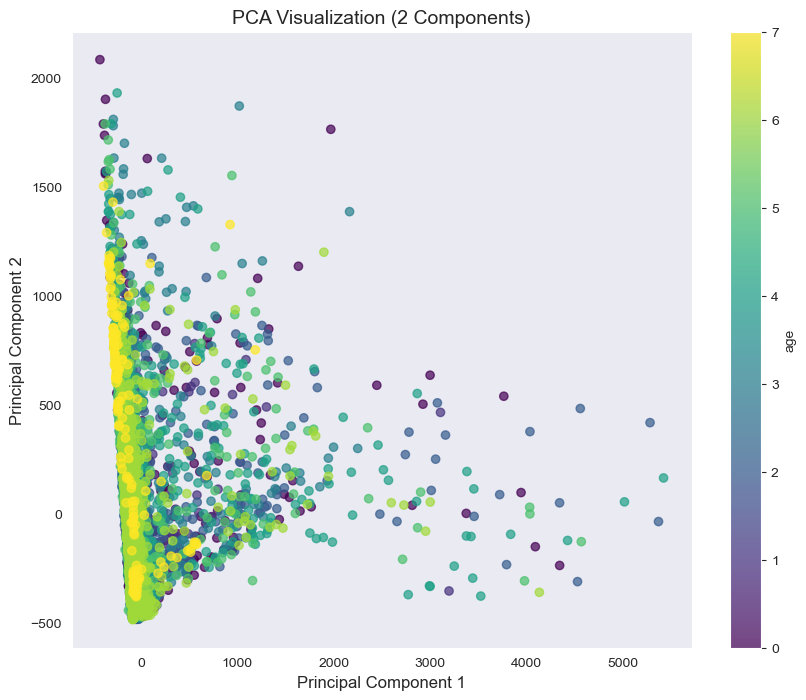

gender


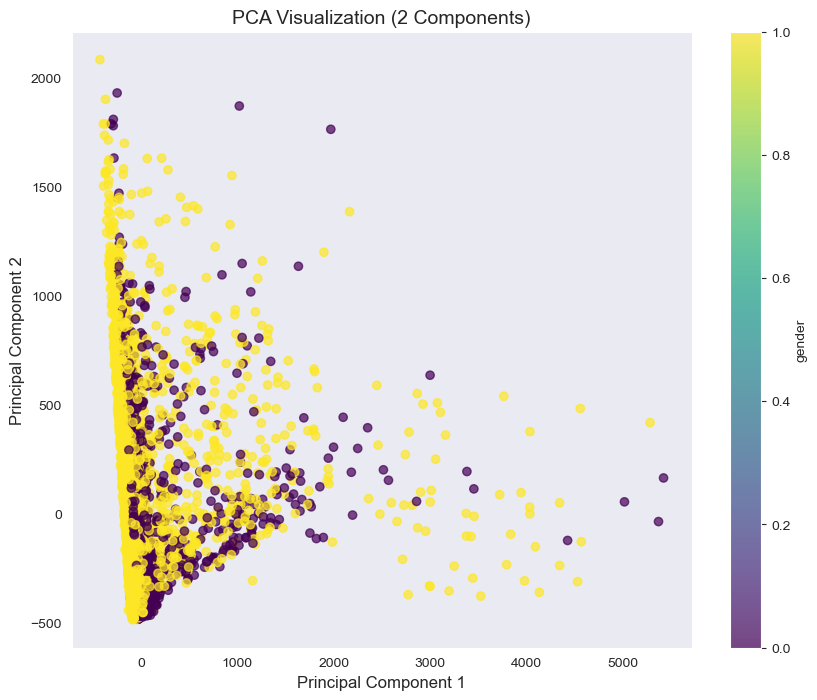

accent


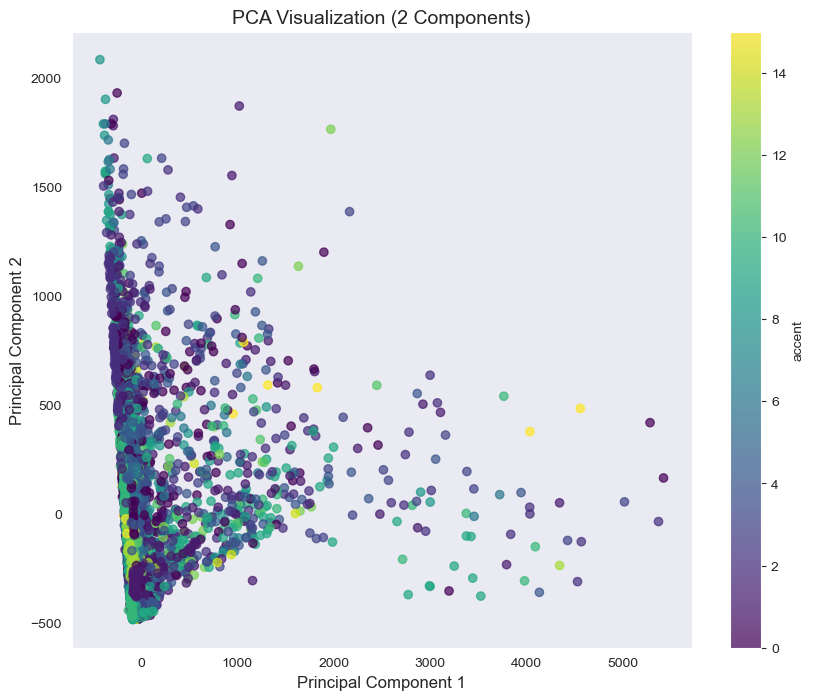

In [106]:
for dataframe in [df_first_13,df_features_transform]:
    for target in targets:
        draw_2d_PCA(dataframe, target)

In [109]:
def split_by_feature(df, feature, test_size=0.1):
    # Stratify based on the selected feature
    train_df, test_df = train_test_split(
        df, 
        test_size=test_size, 
        stratify=df[feature],  # Stratify on the selected feature
        random_state=42
    )
    return train_df, test_df
# train_df, test_df = split_by_feature(df_first_13, "age")
# test_df['accent'].value_counts()

In [120]:
def predict(dataframe, target, n_components = 0):
    warnings.filterwarnings("ignore")
    train_df, test_df = split_by_feature(dataframe,target)
    y_train = train_df[target]
    y_test = test_df[target]
    X_train = train_df.drop(columns=["filename", "age","gender","accent"], errors="ignore")
    X_test = test_df.drop(columns=["filename", "age","gender","accent"], errors="ignore")

    if n_components>0:
        pca = PCA(n_components=n_components)
        X_train = pca.fit_transform(X_train)
        X_test = pca.fit_transform(X_test)
        
    model = LogisticRegression(max_iter=1000, random_state=0, solver='lbfgs')
    model.fit(X_train, y_train)
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    # Evaluate the model
    print(f"Classification Report with target: {target} and n_components ={n_components}:")
    print(classification_report(y_test, y_pred))
    print("Accuracy Score:", accuracy_score(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.title(f"Confusion Matrix for {target} with n_components={n_components}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    

age 0
Classification Report with target: age and n_components =0:
              precision    recall  f1-score   support

           0       0.22      0.28      0.25       144
           1       0.14      0.12      0.12        43
           2       0.23      0.36      0.28       149
           3       0.31      0.24      0.27        93
           4       0.16      0.11      0.13       107
           5       0.30      0.21      0.25       102
           6       0.15      0.12      0.14        90
           7       0.22      0.22      0.22        18

    accuracy                           0.23       746
   macro avg       0.22      0.21      0.21       746
weighted avg       0.23      0.23      0.22       746

Accuracy Score: 0.225201072386059


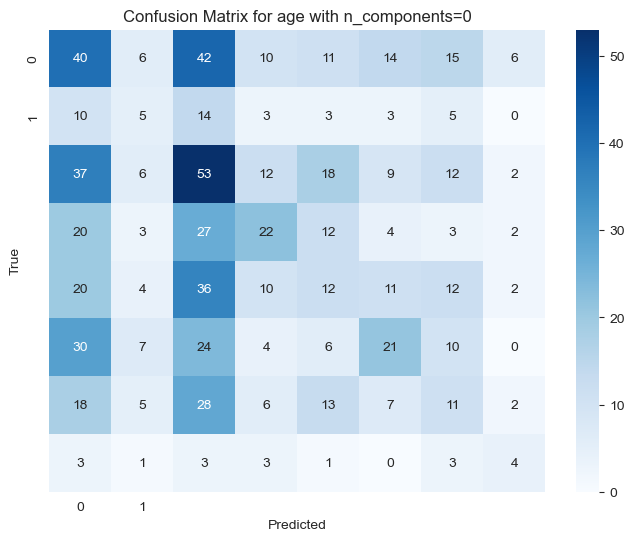

age 2
Classification Report with target: age and n_components =2:
              precision    recall  f1-score   support

           0       0.11      0.04      0.06       144
           1       0.00      0.00      0.00        43
           2       0.20      0.86      0.32       149
           3       0.00      0.00      0.00        93
           4       0.60      0.03      0.05       107
           5       0.09      0.04      0.06       102
           6       0.00      0.00      0.00        90
           7       0.00      0.00      0.00        18

    accuracy                           0.19       746
   macro avg       0.13      0.12      0.06       746
weighted avg       0.16      0.19      0.09       746

Accuracy Score: 0.18900804289544235


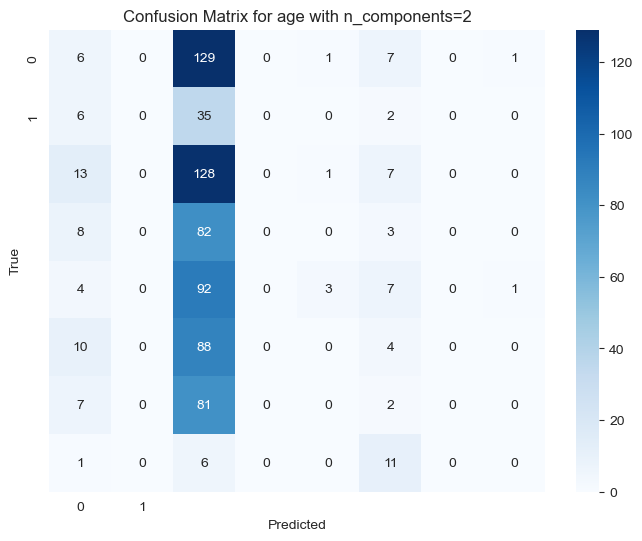

age 91
Classification Report with target: age and n_components =91:
              precision    recall  f1-score   support

           0       0.20      0.32      0.24       144
           1       0.10      0.05      0.06        43
           2       0.20      0.39      0.26       149
           3       0.10      0.04      0.06        93
           4       0.23      0.09      0.13       107
           5       0.14      0.06      0.08       102
           6       0.18      0.09      0.12        90
           7       0.07      0.11      0.09        18

    accuracy                           0.18       746
   macro avg       0.15      0.14      0.13       746
weighted avg       0.17      0.18      0.16       746

Accuracy Score: 0.18230563002680966


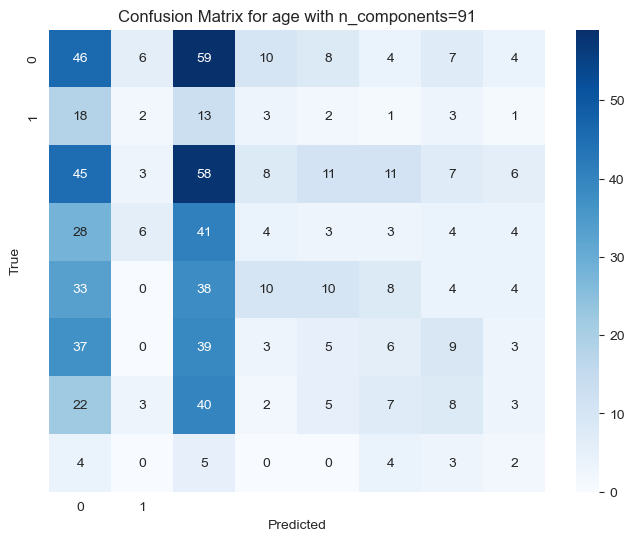

gender 0
Classification Report with target: gender and n_components =0:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75       290
           1       0.85      0.81      0.83       456

    accuracy                           0.80       746
   macro avg       0.79      0.79      0.79       746
weighted avg       0.80      0.80      0.80       746

Accuracy Score: 0.7962466487935657


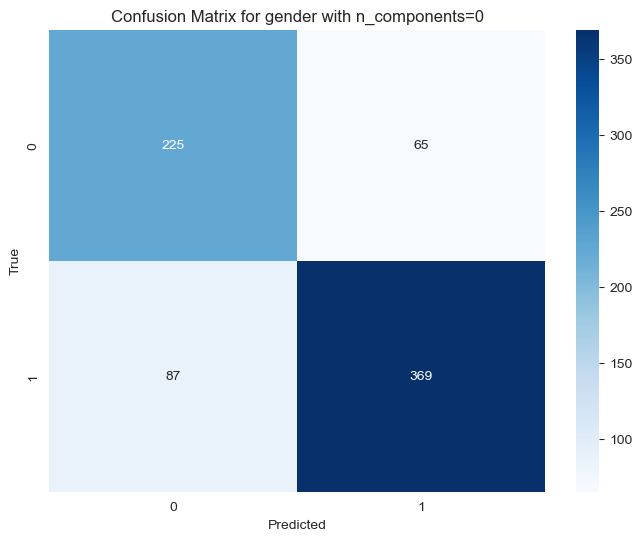

gender 2
Classification Report with target: gender and n_components =2:
              precision    recall  f1-score   support

           0       0.12      0.00      0.01       290
           1       0.61      0.98      0.75       456

    accuracy                           0.60       746
   macro avg       0.37      0.49      0.38       746
weighted avg       0.42      0.60      0.46       746

Accuracy Score: 0.6032171581769437


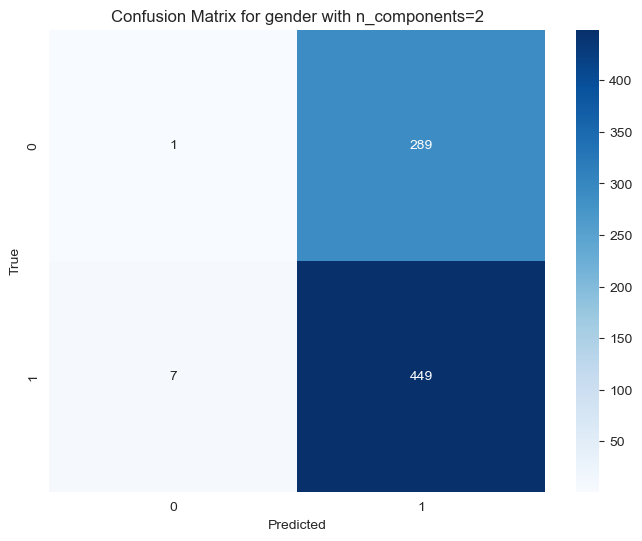

gender 91
Classification Report with target: gender and n_components =91:
              precision    recall  f1-score   support

           0       0.29      0.24      0.26       290
           1       0.56      0.62      0.59       456

    accuracy                           0.47       746
   macro avg       0.42      0.43      0.42       746
weighted avg       0.45      0.47      0.46       746

Accuracy Score: 0.47050938337801607


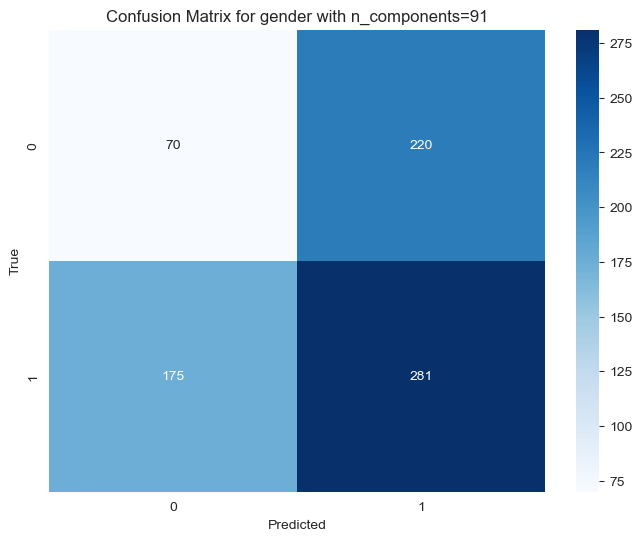

accent 0
Classification Report with target: accent and n_components =0:
              precision    recall  f1-score   support

           0       0.17      0.10      0.13        99
           1       0.15      0.22      0.18       101
           2       0.15      0.09      0.12        86
           3       0.34      0.21      0.26        52
           4       0.21      0.26      0.23        90
           5       0.10      0.13      0.11        15
           6       0.23      0.20      0.22        44
           7       0.05      0.05      0.05        19
           8       0.20      0.18      0.19        51
           9       0.18      0.18      0.18        60
          10       0.06      0.06      0.06        48
          11       0.13      0.18      0.15        22
          12       0.16      0.23      0.19        30
          13       0.05      0.08      0.06        12
          14       0.15      0.30      0.20        10
          15       0.50      0.29      0.36         7

    accu

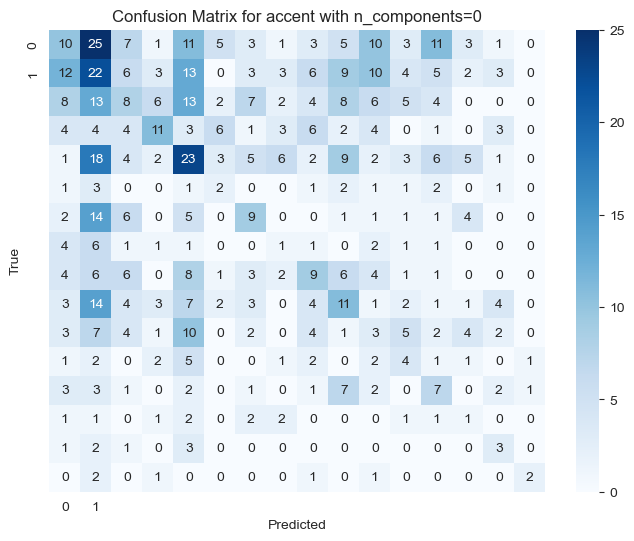

accent 2
Classification Report with target: accent and n_components =2:
              precision    recall  f1-score   support

           0       0.13      0.33      0.19        99
           1       0.13      0.58      0.22       101
           2       0.09      0.02      0.04        86
           3       0.15      0.10      0.12        52
           4       0.00      0.00      0.00        90
           5       0.00      0.00      0.00        15
           6       0.00      0.00      0.00        44
           7       0.00      0.00      0.00        19
           8       0.00      0.00      0.00        51
           9       0.33      0.02      0.03        60
          10       0.00      0.00      0.00        48
          11       0.00      0.00      0.00        22
          12       0.00      0.00      0.00        30
          13       0.00      0.00      0.00        12
          14       0.00      0.00      0.00        10
          15       0.00      0.00      0.00         7

    accu

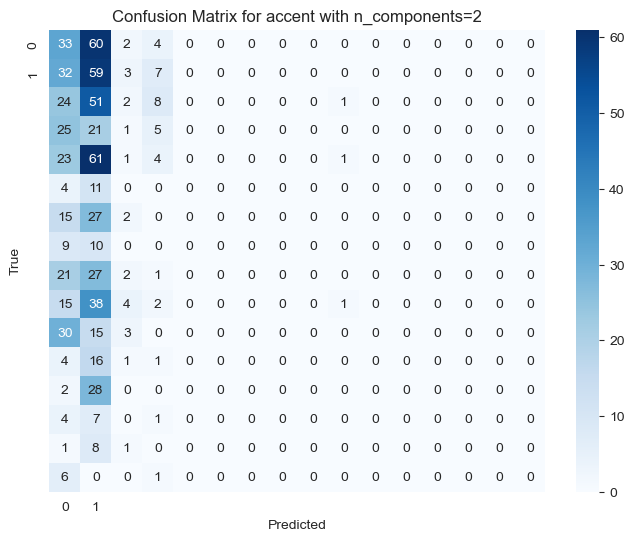

accent 91
Classification Report with target: accent and n_components =91:
              precision    recall  f1-score   support

           0       0.07      0.06      0.06        99
           1       0.08      0.09      0.08       101
           2       0.08      0.10      0.09        86
           3       0.12      0.06      0.08        52
           4       0.12      0.27      0.17        90
           5       0.00      0.00      0.00        15
           6       0.11      0.09      0.10        44
           7       0.00      0.00      0.00        19
           8       0.14      0.10      0.11        51
           9       0.07      0.03      0.04        60
          10       0.03      0.02      0.02        48
          11       0.00      0.00      0.00        22
          12       0.00      0.00      0.00        30
          13       0.11      0.08      0.10        12
          14       0.00      0.00      0.00        10
          15       0.00      0.00      0.00         7

    ac

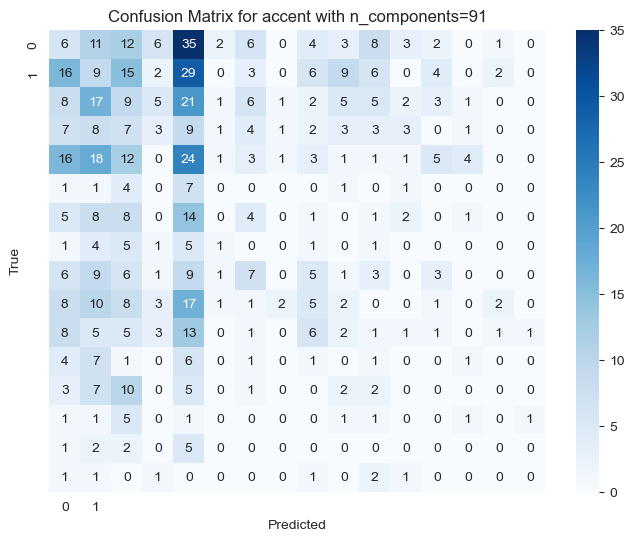

In [122]:
for target in targets:
    for i in [0,2,91]:
        print(target, i)
        predict(df_features_transform , target, n_components = i)


age 0
Classification Report with target: age and n_components =0:
              precision    recall  f1-score   support

           0       0.21      0.39      0.27       144
           1       0.00      0.00      0.00        43
           2       0.21      0.64      0.32       149
           3       0.14      0.01      0.02        93
           4       0.14      0.03      0.05       107
           5       0.00      0.00      0.00       102
           6       0.00      0.00      0.00        90
           7       0.00      0.00      0.00        18

    accuracy                           0.21       746
   macro avg       0.09      0.13      0.08       746
weighted avg       0.12      0.21      0.13       746

Accuracy Score: 0.20777479892761394


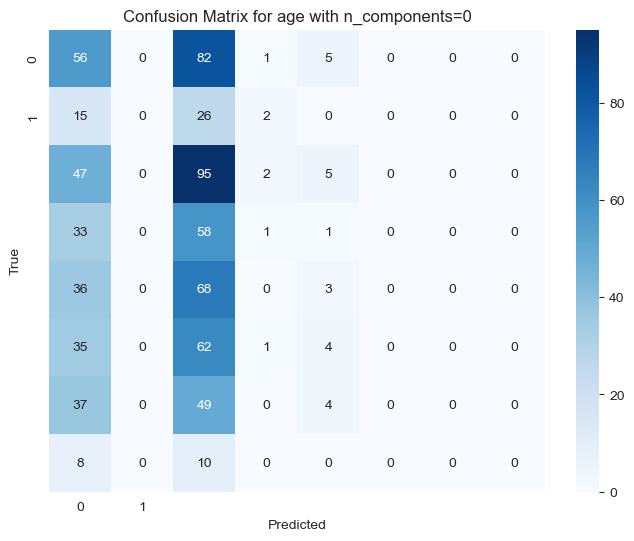

age 2
Classification Report with target: age and n_components =2:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       144
           1       0.00      0.00      0.00        43
           2       0.20      0.99      0.33       149
           3       0.00      0.00      0.00        93
           4       0.60      0.03      0.05       107
           5       0.00      0.00      0.00       102
           6       0.00      0.00      0.00        90
           7       0.00      0.00      0.00        18

    accuracy                           0.20       746
   macro avg       0.10      0.13      0.05       746
weighted avg       0.13      0.20      0.07       746

Accuracy Score: 0.20241286863270777


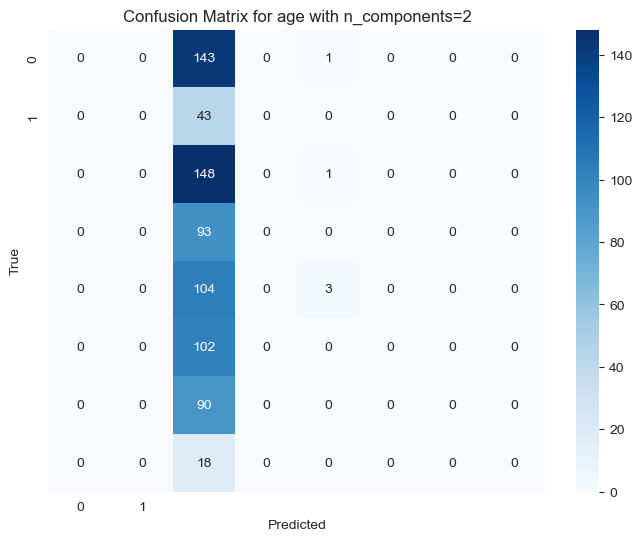

gender 0
Classification Report with target: gender and n_components =0:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       290
           1       0.90      0.91      0.90       456

    accuracy                           0.88       746
   macro avg       0.88      0.87      0.88       746
weighted avg       0.88      0.88      0.88       746

Accuracy Score: 0.8820375335120644


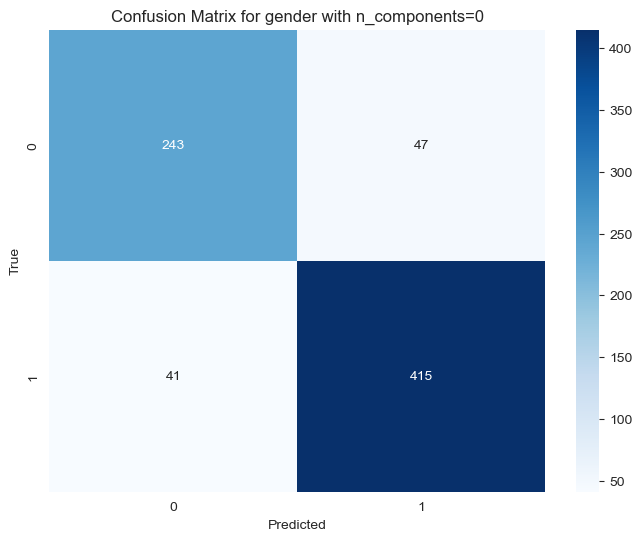

gender 2
Classification Report with target: gender and n_components =2:
              precision    recall  f1-score   support

           0       0.32      0.03      0.06       290
           1       0.61      0.96      0.74       456

    accuracy                           0.60       746
   macro avg       0.47      0.49      0.40       746
weighted avg       0.50      0.60      0.48       746

Accuracy Score: 0.5978552278820375


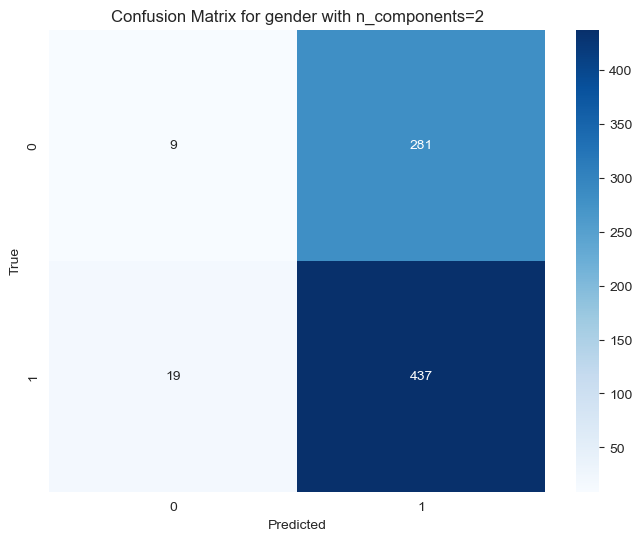

accent 0
Classification Report with target: accent and n_components =0:
              precision    recall  f1-score   support

           0       0.13      0.34      0.19        99
           1       0.14      0.48      0.22       101
           2       0.12      0.01      0.02        86
           3       0.27      0.21      0.24        52
           4       0.12      0.11      0.11        90
           5       0.00      0.00      0.00        15
           6       0.00      0.00      0.00        44
           7       0.00      0.00      0.00        19
           8       0.20      0.02      0.04        51
           9       0.00      0.00      0.00        60
          10       0.00      0.00      0.00        48
          11       0.00      0.00      0.00        22
          12       0.00      0.00      0.00        30
          13       0.00      0.00      0.00        12
          14       0.00      0.00      0.00        10
          15       0.00      0.00      0.00         7

    accu

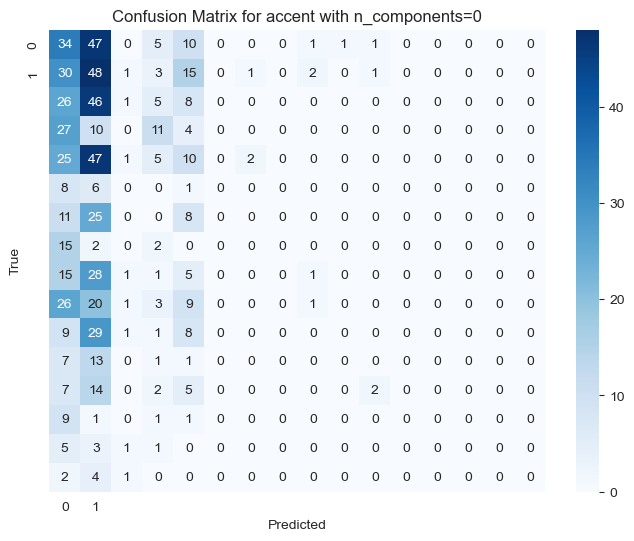

accent 2
Classification Report with target: accent and n_components =2:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        99
           1       0.14      0.97      0.24       101
           2       0.12      0.03      0.05        86
           3       0.00      0.00      0.00        52
           4       0.00      0.00      0.00        90
           5       0.00      0.00      0.00        15
           6       0.00      0.00      0.00        44
           7       0.00      0.00      0.00        19
           8       0.00      0.00      0.00        51
           9       0.20      0.02      0.03        60
          10       0.00      0.00      0.00        48
          11       0.00      0.00      0.00        22
          12       0.00      0.00      0.00        30
          13       0.00      0.00      0.00        12
          14       0.00      0.00      0.00        10
          15       0.00      0.00      0.00         7

    accu

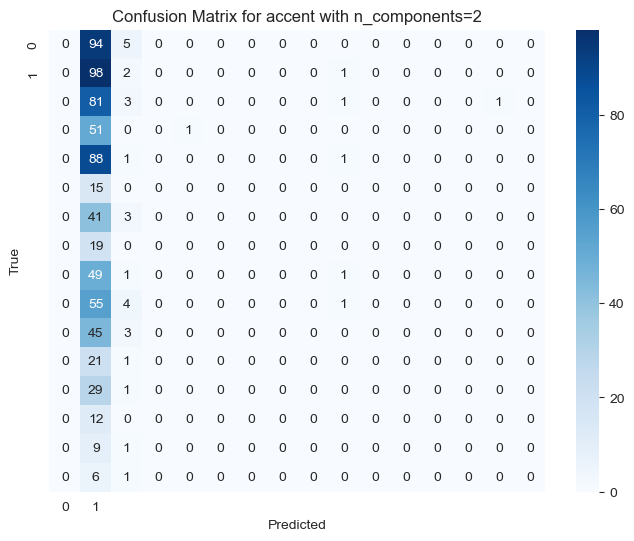

In [123]:
for target in targets:
    for i in [0,2]:
        print(target, i)
        predict(df_first_13 , target, n_components = i)

In [125]:
# Test
train_df, test_df = split_by_feature(df_features_transform,"age")
y_train = train_df["age"]
y_test = test_df["age"]
X_train = train_df.drop(columns=["filename", "age","gender","accent"], errors="ignore")
X_test = test_df.drop(columns=["filename", "age","gender","accent"], errors="ignore")

In [127]:
# Create pipeline
pipe = Pipeline(
    [
        ("scaler", RobustScaler()),
        ("pca", PCA()),
        ("logreg", LogisticRegression(class_weight="balanced")),
    ]
)

# Create grid
grid = {
    "scaler": [RobustScaler(), PowerTransformer(), QuantileTransformer()],
    "pca": [None, PCA(0.99)],
    "logreg__C": np.logspace(-3, 2, num=16),
}

# Create GridSearchCV
grid_cv = GridSearchCV(pipe, grid, cv=4, return_train_score=True, verbose=3)

# Train GridSearchCV
model = grid_cv.fit(X_train, y_train)

# Collect results in a DataFrame
cv_results = pd.DataFrame(grid_cv.cv_results_)

# Select the columns we are interested in
col_of_interest = [
    "param_scaler",
    "param_pca",
    "param_logreg__C",
    "mean_test_score",
    "mean_train_score",
    "std_test_score",
    "std_train_score",
]
cv_results = cv_results[col_of_interest]

# Show the dataframe sorted according to our performance metric
cv_results.sort_values("mean_test_score", ascending=False)

Fitting 4 folds for each of 96 candidates, totalling 384 fits
[CV 1/4] END logreg__C=0.001, pca=None, scaler=RobustScaler();, score=(train=0.323, test=0.218) total time=   0.4s
[CV 2/4] END logreg__C=0.001, pca=None, scaler=RobustScaler();, score=(train=0.329, test=0.226) total time=   0.4s
[CV 3/4] END logreg__C=0.001, pca=None, scaler=RobustScaler();, score=(train=0.330, test=0.222) total time=   0.4s
[CV 4/4] END logreg__C=0.001, pca=None, scaler=RobustScaler();, score=(train=0.320, test=0.239) total time=   0.4s
[CV 1/4] END logreg__C=0.001, pca=None, scaler=PowerTransformer();, score=(train=0.340, test=0.265) total time=   2.6s
[CV 2/4] END logreg__C=0.001, pca=None, scaler=PowerTransformer();, score=(train=0.337, test=0.275) total time=   2.2s
[CV 3/4] END logreg__C=0.001, pca=None, scaler=PowerTransformer();, score=(train=0.346, test=0.265) total time=   2.2s
[CV 4/4] END logreg__C=0.001, pca=None, scaler=PowerTransformer();, score=(train=0.338, test=0.292) total time=   2.2s
[C

,param_scaler,param_pca,param_logreg__C,mean_test_score,mean_train_score,std_test_score,std_train_score
32,QuantileTransformer(),None,0.046416,0.286847,0.403020,0.019071,0.004332
13,PowerTransformer(),None,0.004642,0.285506,0.416630,0.018411,0.002583
38,QuantileTransformer(),None,0.100000,0.284910,0.432574,0.018475,0.003142
10,PowerTransformer(),PCA(n_components=0.99),0.002154,0.284760,0.370784,0.016092,0.003582
16,PowerTransformer(),PCA(n_components=0.99),0.004642,0.284612,0.406199,0.017504,0.002348
...,...,...,...,...,...,...,...
93,RobustScaler(),PCA(n_components=0.99),100.000000,0.215170,0.432425,0.005299,0.007283
84,RobustScaler(),None,46.415888,0.214874,0.460190,0.012622,0.005612
81,RobustScaler(),PCA(n_components=0.99),21.544347,0.214276,0.432127,0.005526,0.008098
5,QuantileTransformer(),PCA(n_components=0.99),0.001000,0.195948,0.216064,0.007840,0.009143


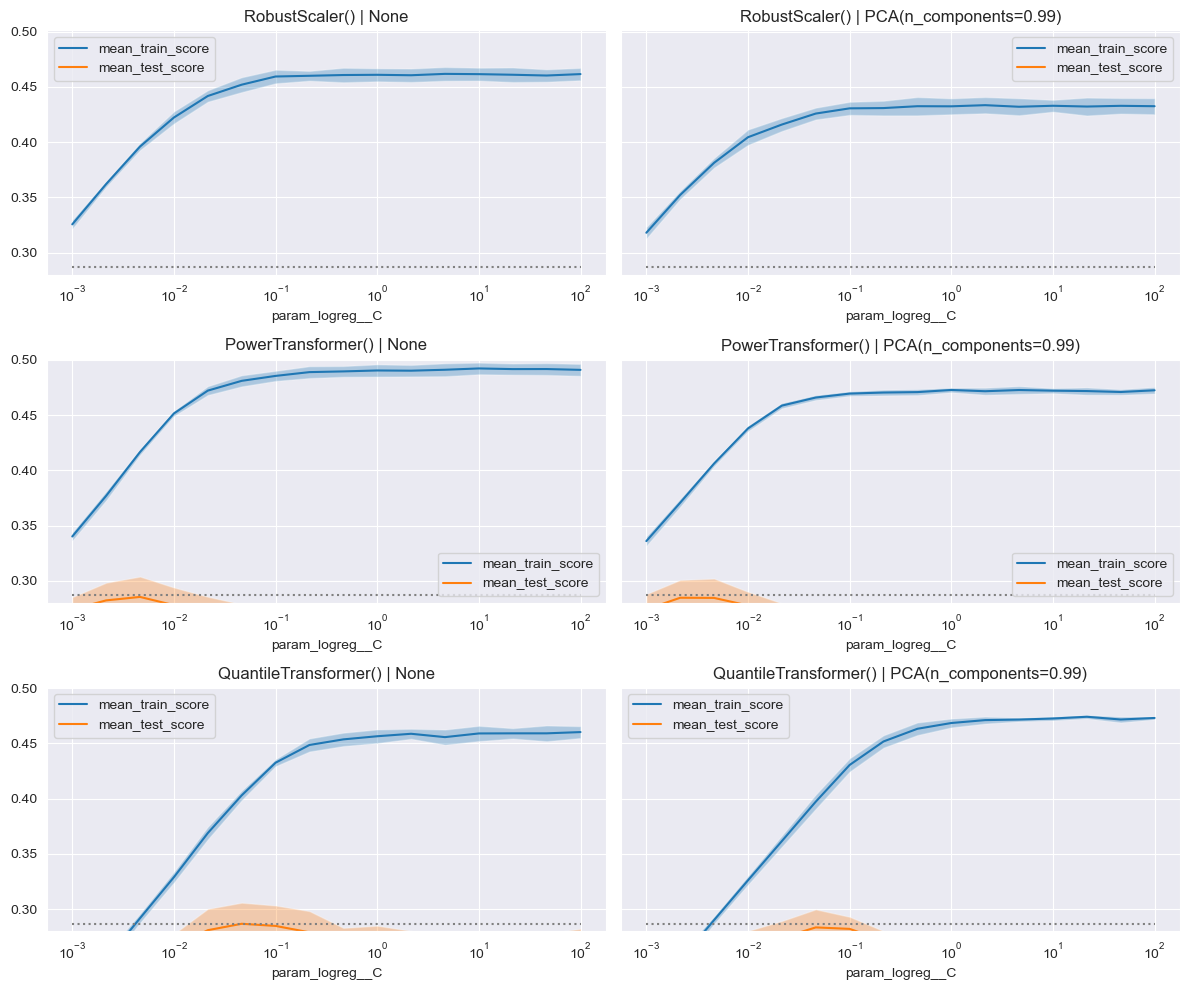

In [132]:
combinations = list(product(grid["scaler"], grid["pca"]))

# Creates a figure with multiple subplot
fig, axs = plt.subplots(
    len(grid["scaler"]), len(grid["pca"]), figsize=(12, 10), sharey=True)

# Extract useful information about max performance
max_score = cv_results["mean_test_score"].max()
c_values = cv_results["param_logreg__C"]

# Loop through the subplots and populate them
for i, (s, p) in enumerate(combinations):

    # Select subplot relevant grid search results
    mask = np.logical_and(
        cv_results["param_pca"].astype("str") == str(p),
        cv_results["param_scaler"].astype("str") == str(s),
    )
    df_cv = cv_results[mask].sort_values("param_logreg__C").set_index("param_logreg__C")

    # Select relevant axis
    ax = axs.flatten()[i]

    # Plot train and test curves
    df_cv[["mean_train_score", "mean_test_score"]].plot(
        logx=True, title=f"{s} | {p}", ax=ax)
    ax.fill_between(
        df_cv.index,
        df_cv["mean_train_score"] - df_cv["std_train_score"],
        df_cv["mean_train_score"] + df_cv["std_train_score"],
        alpha=0.3,)
    ax.fill_between(
        df_cv.index,
        df_cv["mean_test_score"] - df_cv["std_test_score"],
        df_cv["mean_test_score"] + df_cv["std_test_score"],
        alpha=0.3,)

    # Plot best performance metric as dotted line
    ax.hlines(
        max_score, c_values.min(), c_values.max(), color="gray", linestyles="dotted")

# Limit y-axis
plt.ylim(0.28, 0.501)
plt.tight_layout()
plt.show()

In [133]:
# Compute score of the best model on the withheld test set
best_clf = model.best_estimator_
best_clf.score(X_test, y_test)

0.30160857908847183

# Single Test: preprocessing

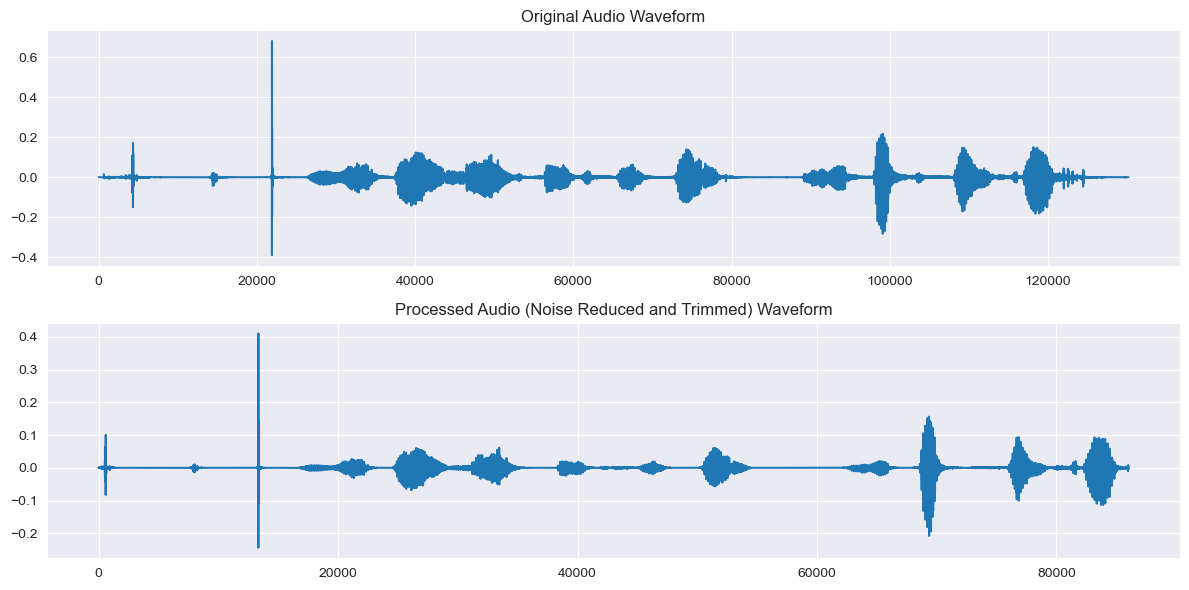

In [154]:
mp3_filename = "cv-valid-train/sample-006319.mp3" 
mp3_file_path = os.path.join(mp3_folder, mp3_filename)
y, sr1 = librosa.load(mp3_file_path)
y_trim,sr2 = preprocessing(mp3_file_path)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(y)
plt.title('Original Audio Waveform')

plt.subplot(2, 1, 2)
plt.plot(y_trim)
plt.title('Processed Audio (Noise Reduced and Trimmed) Waveform')

plt.tight_layout()
plt.show()

In [155]:
sr1

22050

# Single Test: Onset

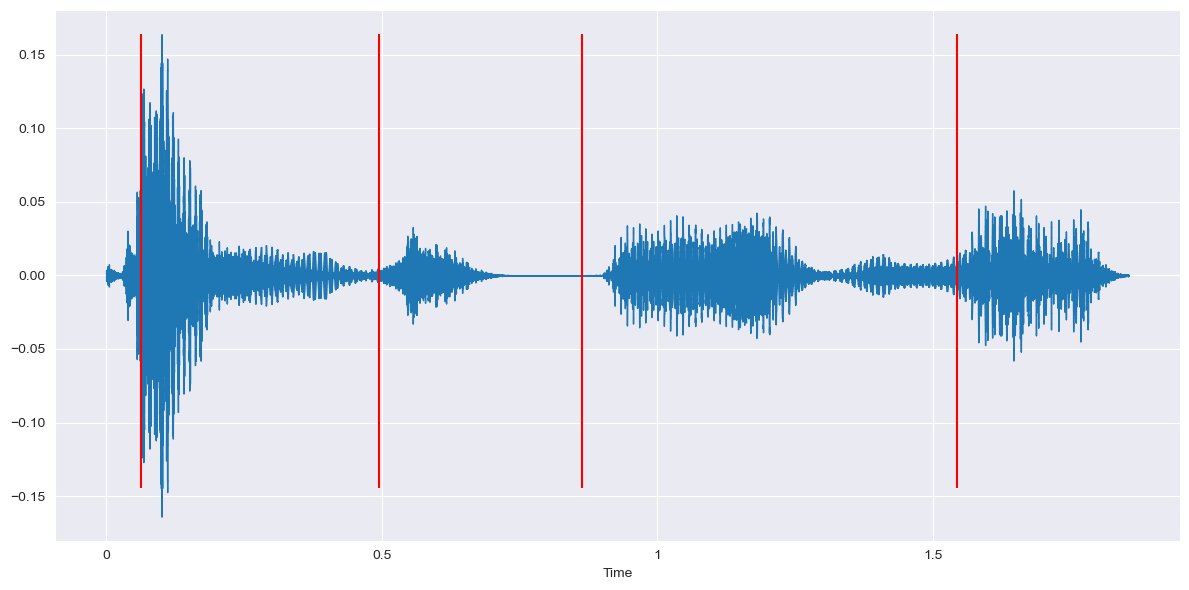

4 onsets were detected in this audio signal.
1.856


In [138]:
onsets = librosa.onset.onset_detect(y=y_trim, sr=sr, units="time", hop_length=128, backtrack=True)
plt.figure(figsize=(12, 6))
for o in onsets:
    plt.vlines(o, min(y_trim), max(y_trim), colors="r")
librosa.display.waveshow(y_trim,sr=sr)
plt.tight_layout()
plt.show()
# Return number of onsets
number_of_words = len(onsets)
print(f"{number_of_words} onsets were detected in this audio signal.")

duration = librosa.get_duration(y=y_trim,sr=sr)
print(duration)

In [140]:
sr2

22050

# Single Test: Fundamental frequency

In [366]:
f0_values = pitch(y=y_trim, sr=sr)

# Single Test: FFT

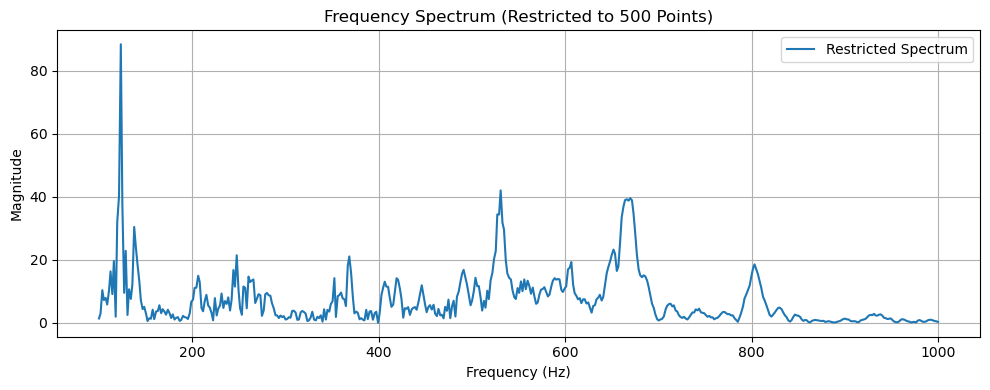

In [367]:
r = fft(y_trim,sr)
sampled_frequencies = r.keys()
sampled_magnitudes = r.values()
# Plot the restricted spectrum
plt.figure(figsize=(10, 4))
plt.plot(sampled_frequencies, sampled_magnitudes, label="Restricted Spectrum")
plt.title("Frequency Spectrum (Restricted to 500 Points)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [131]:
mp3_filename = "cv-valid-train/sample-000020.mp3" 
mp3_file_path = os.path.join(mp3_folder, mp3_filename)
y, sr = librosa.load(mp3_file_path)

reduced_noise = nr.reduce_noise(y=y, sr=sr, stationary=False)
y_trim, _ = librosa.effects.trim(reduced_noise, top_db=20)
f0 = pitch(y_trim,sr)
print(f0)
print(y_trim.shape)
if len(y_trim) < 5 * 16000:
    print("pad")
    y_trim = np.pad(y_trim, (0, 5 * 16000 - len(y_trim)), mode='constant')
else:
    y_trim = y_trim[:5 * 16000]
print(y_trim.shape)
f0 = pitch(y_trim,sr)
print(f0)


{'f0_mean': 136.40504494925526, 'f0_median': 127.72774181706397, 'f0_std': 27.503920468108696, 'f0_5-percentile': 107.40580022242106, 'f0_95-percentile': 200.4263101798605}
(108032,)
(80000,)
{'f0_mean': 441.6696881351632, 'f0_median': 143.78480836182263, 'f0_std': 759.2268896618101, 'f0_5-percentile': 116.45225462737498, 'f0_95-percentile': 2430.3158296333286}
